In [1]:
import os
import json
import importlib

import glob as gb
import utils as ut
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as pyw
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import HTML, display, clear_output

In [2]:
importlib.reload(ut);

In [3]:
%matplotlib inline

# Global

In [4]:
dark_mode = True

In [5]:
plt.rcParams['text.usetex'] = True
plt.style.use(['dark_background' if dark_mode else 'default'])

In [6]:
pd.set_option('display.max_colwidth', None)

# Data

## Load

In [7]:
# load data
path = os.path.join('data', 'input', 'v10*', '**', '*.zip')
data = ut.load_data(path, limit=1)

extract /tmp/tmpe3jfb02y/AOS-Simulation-2021-09-11-13-14-36
extract /tmp/tmpe3jfb02y/AOS-Simulation-2021-09-11-13-14-53
extract /tmp/tmpe3jfb02y/AOS-Simulation-2021-09-11-13-15-07
extract /tmp/tmpe3jfb02y/AOS-Simulation-2021-09-11-13-15-21
extract /tmp/tmpe3jfb02y/AOS-Simulation-2021-09-11-13-15-32
extract /tmp/tmpe3jfb02y/AOS-Simulation-2021-09-11-13-15-46
extract /tmp/tmpe3jfb02y/AOS-Simulation-2021-09-11-13-15-58
extract /tmp/tmpe3jfb02y/AOS-Simulation-2021-09-11-13-16-12


In [8]:
# select simulation
index = 4
simulation = list(data.keys())[index]
print('simulations:\n', '\n '.join([f'{i:02d}: ' + (f'{x} [x]' if x == simulation else x) for i, x in enumerate(list(data.keys()))]))

simulations:
 00: AOS-Simulation-2021-09-11-13-14-36
 01: AOS-Simulation-2021-09-11-13-14-53
 02: AOS-Simulation-2021-09-11-13-15-07
 03: AOS-Simulation-2021-09-11-13-15-21
 04: AOS-Simulation-2021-09-11-13-15-32 [x]
 05: AOS-Simulation-2021-09-11-13-15-46
 06: AOS-Simulation-2021-09-11-13-15-58
 07: AOS-Simulation-2021-09-11-13-16-12


## Preview

In [9]:
# show images
df_images = data[simulation]['images']
df_images.filter(regex=r'^(?:(?!data).)*$')

,number,name,type,x,y,z,url
0,1,image-1-monochrome.png,monochrome,-51.0,0.0,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-51.00&drone.northSouth=-19.00&drone.camera.view=50
1,2,image-2-monochrome.png,monochrome,-50.0,0.0,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-50.00&drone.northSouth=-19.00&drone.camera.view=50
2,3,image-3-monochrome.png,monochrome,-49.0,0.0,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-49.00&drone.northSouth=-19.00&drone.camera.view=50
3,4,image-4-monochrome.png,monochrome,-48.0,0.0,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-48.00&drone.northSouth=-19.00&drone.camera.view=50
4,5,image-5-monochrome.png,monochrome,-47.0,0.0,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-47.00&drone.northSouth=-19.00&drone.camera.view=50
...,...,...,...,...,...,...,...
304,305,image-305-monochrome.png,monochrome,47.0,0.0,46.283073,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=47.00&drone.northSouth=46.28&drone.camera.view=50
305,306,image-306-monochrome.png,monochrome,48.0,0.0,46.283073,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=48.00&drone.northSouth=46.28&drone.camera.view=50
306,307,image-307-monochrome.png,monochrome,49.0,0.0,46.283073,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=49.00&drone.northSouth=46.28&drone.camera.view=50
307,308,image-308-monochrome.png,monochrome,50.0,0.0,46.283073,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=50.00&drone.northSouth=46.28&drone.camera.view=50


In [10]:
# show trees
df_trees = data[simulation]['trees']
df_trees

,tree,position.x,position.y,position.z,box.min.x,box.min.y,box.min.z,box.max.x,box.max.y,box.max.z
0,3,-23.378712,0.0,44.097115,-26.431494,0.0,41.027515,-20.325928,24.361893,47.166714
1,4,-31.343758,0.0,39.550213,-34.348366,0.0,36.529053,-28.339148,23.977461,42.571373
2,6,42.119030,0.0,-37.224316,39.099293,0.0,-40.260689,45.138767,24.098186,-34.187946
3,10,-43.613873,0.0,40.913826,-46.746616,0.0,37.763824,-40.481129,25.000000,44.063828
4,12,15.224713,0.0,12.413972,12.091969,0.0,9.263971,18.357458,25.000000,15.563972
...,...,...,...,...,...,...,...,...,...,...
155,295,34.871056,0.0,29.452879,31.873665,0.0,26.438980,37.868443,23.919842,32.466778
156,297,14.287553,0.0,11.282220,11.257990,0.0,8.235970,17.317116,24.176592,14.328471
157,298,25.795835,0.0,20.282452,22.758898,0.0,17.228786,28.832773,24.235439,23.336117
158,299,-30.279554,0.0,21.780756,-33.261520,0.0,18.782368,-27.297590,23.796740,24.779146


In [11]:
# show persons
df_persons = data[simulation]['persons']
df_persons

""


In [12]:
# show parameters
parameters = data[simulation]['parameters']
print('parameters:', json.dumps(parameters, indent=4))

parameters: {
    "drone": {
        "speed": 10,
        "height": 35,
        "rotation": 0,
        "camera": {
            "view": 50,
            "resolution": 512,
            "sampling": 1,
            "type": "monochrome"
        },
        "coverage": 32.6415360708499
    },
    "forest": {
        "size": 300,
        "ground": 70,
        "persons": {
            "count": 0,
            "activities": {
                "laying": true,
                "sitting": false,
                "standing": true,
                "waving": true,
                "injured": false,
                "walking": true,
                "running": false
            }
        }
    },
    "material": {
        "color": {
            "tree": 6370837,
            "twig": 5601109,
            "ground": 65793,
            "plane": 16777215,
            "person": 16744319,
            "background": 8900331
        }
    },
    "capture": true,
    "preset": "forest-21",
    "next": 4,
    "url": "https:/

In [13]:
# show subsamples
N, M = ut.sample_data(parameters)
print('subsamples:', json.dumps({'N': N, 'M': M}, indent=4))

subsamples: {
    "N": {
        "33": 1,
        "16": 2,
        "11": 3,
        "8": 4,
        "7": 5,
        "5": 7,
        "4": 8,
        "3": 11,
        "2": 16,
        "1": 33
    },
    "M": {
        "33": 1.0,
        "16": 2.0,
        "11": 3.0,
        "8": 4.0,
        "7": 5.0,
        "5": 7.0,
        "4": 8.0,
        "3": 11.0,
        "2": 16.0,
        "1": 33.0
    }
}


# Plots

## Original Images

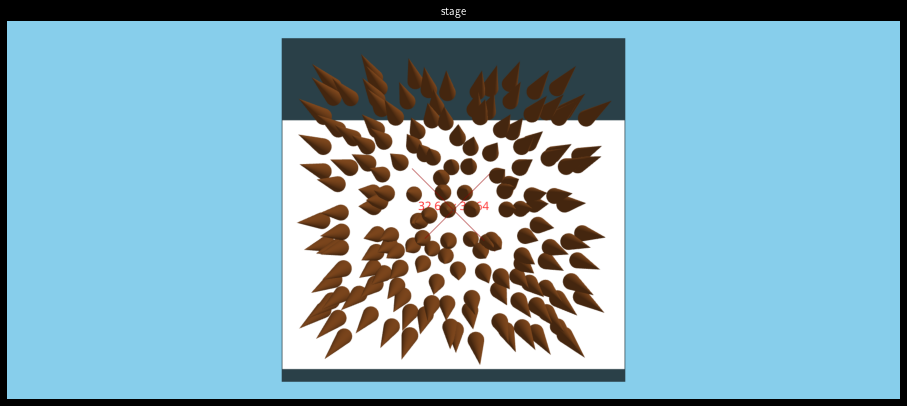

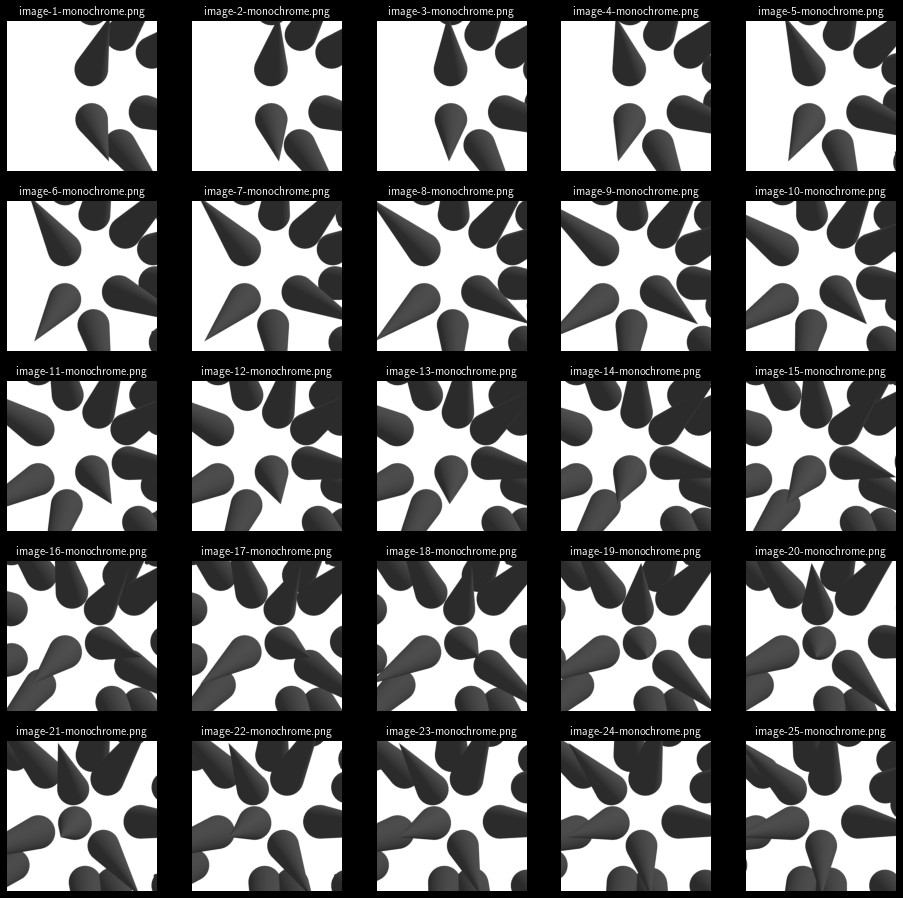

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))

# plot stage image
ut.plot_image(ax, data[simulation]['stage'], 'stage')

# plot first images
ut.plot_images(df_images['data'], df_images['name']);

## Sampled Images

In [15]:
df_sampled = df_images.iloc[::N[1], :][['number', 'x', 'z', 'url']]

# simulation urls
display(HTML(df_sampled.style.format({'url': lambda x: f'<a onclick="document.getElementById(\'aos-simulation\').src=\'{x}\'">{x}</a>'})._repr_html_()))

,number,x,z,url
0,1,-51.000000,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-51.00&drone.northSouth=-19.00&drone.camera.view=50
33,34,-18.000000,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-18.00&drone.northSouth=-19.00&drone.camera.view=50
66,67,15.000000,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=15.00&drone.northSouth=-19.00&drone.camera.view=50
99,100,48.000000,-19.000000,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=48.00&drone.northSouth=-19.00&drone.camera.view=50
132,133,22.000000,13.641536,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=22.00&drone.northSouth=13.64&drone.camera.view=50
165,166,-11.000000,13.641536,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-11.00&drone.northSouth=13.64&drone.camera.view=50
198,199,-44.000000,13.641536,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-44.00&drone.northSouth=13.64&drone.camera.view=50
231,232,-26.000000,46.283073,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=-26.00&drone.northSouth=46.28&drone.camera.view=50
264,265,7.000000,46.283073,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=7.00&drone.northSouth=46.28&drone.camera.view=50
297,298,40.000000,46.283073,https://aos.tensorware.app/#preset=forest-21&drone.height=35&drone.rotation=0&drone.eastWest=40.00&drone.northSouth=46.28&drone.camera.view=50


In [16]:
# simulation iframe
# display(HTML(f'<iframe id="aos-simulation" src="{parameters["url"]}" width="1028" height="720" frameborder="0" allowfullscreen>'))

## Integrated Images

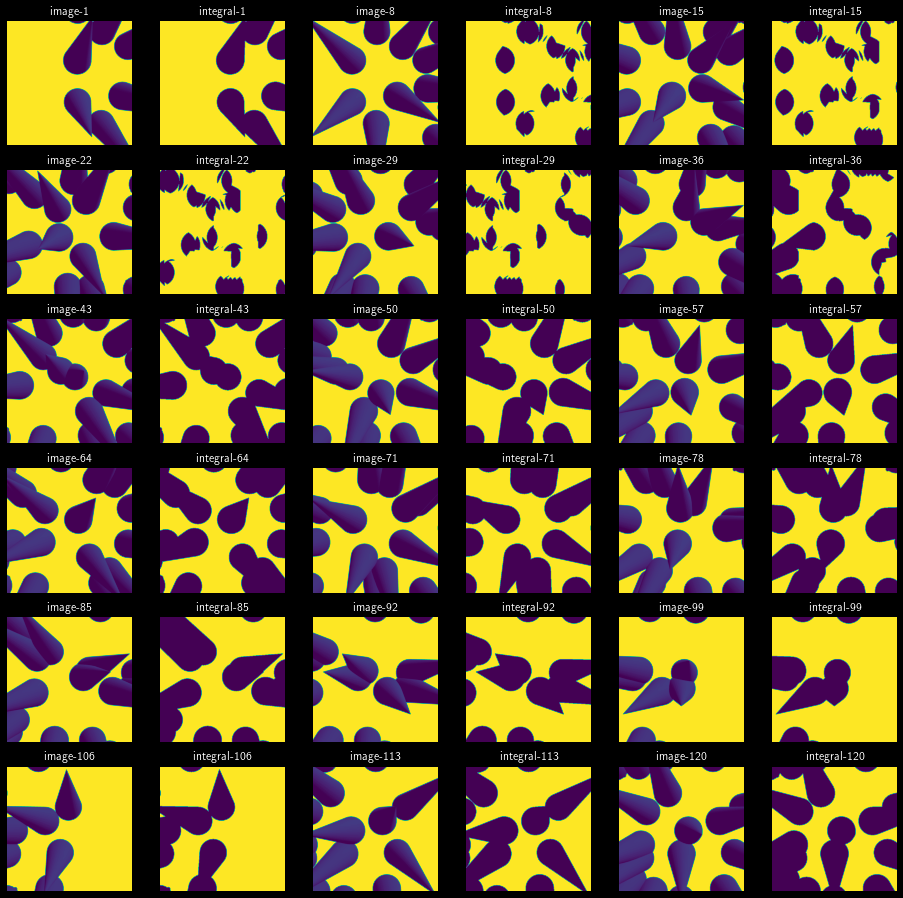

In [17]:
df_integrate = df_images.iloc[::N[5], :].head(18)

# integrate images
integrated = ut.integrate_image(df_integrate, parameters, N=30)

# grayscale images
grayscaled = np.array([ut.grayscale_image(x) for x in df_integrate['data']])

# stack integrated images
image_vs_integrated = np.hstack([grayscaled, integrated]).reshape(integrated.shape * np.array([2, 1, 1]))
image_vs_integrated_labels = np.dstack(['image-' + df_integrate['number'].astype(np.str), 'integral-' + df_integrate['number'].astype(np.str)]).flatten()

# plot integrated images
ut.plot_images(image_vs_integrated, image_vs_integrated_labels, rows=6, cols=6);

## Integrated Ground

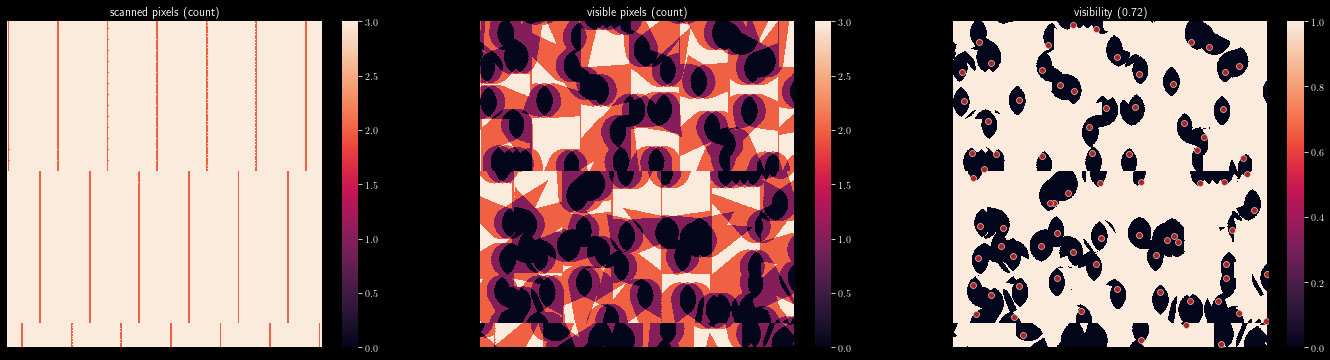

In [18]:
df_integrate = df_images.iloc[::N[3], :]

# integrate ground
ground, alphas = ut.integrate_ground(df_integrate, parameters)

# calculate statistics
statistics = ut.calculate_statistics(df_integrate, df_trees, ground, parameters)

# plot integrated ground
fig, axs = ut.plot_ground(ground, ['scanned pixels (count)', 'visible pixels (count)', f'visibility ({statistics["ground_visibility"]:.2f})'])

# plot tree positions
ground_rect = [[0, ground.shape[0]], [0, ground.shape[1]]]
trees_pos = ut.ground_positions(df_trees[['position.x', 'position.z']], ground_rect, parameters)
axs[2].scatter(*trees_pos.T, marker='o', facecolor='firebrick', edgecolor='lightgray', linewidth=0.7);

## Statistics

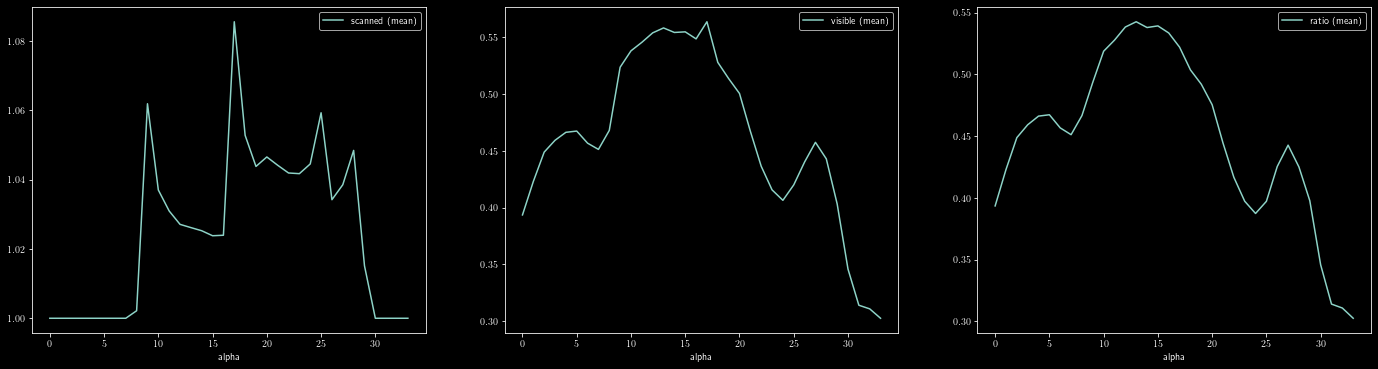

In [19]:
# aggregate alphas
df_alphas = ut.aggregate_alphas(alphas, sample=None)

# plot aggregated alphas
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
for i, column in enumerate(['scanned', 'visible', 'ratio']):
    df_alphas.plot(kind='line', x='alpha', y=column, label=f'{column} (mean)', ax=axs[i])

In [20]:
# print overall density
print('density (from mean):', 1 - (ground[:, :, 1] > 0).mean())
print('density (from visibility):', 1 - statistics['ground_visibility'])

density (from mean): 0.2862468204907891
density (from visibility): 0.28494375699291385


In [21]:
# print average trees per image
print('trees per image:', statistics['trees_per_image'])

trees per image: 17.615384615384617
